In [16]:
# install the necessary libraries
# !pip install gym
# !pip install pygame
# !pip install opencv-python
# !pip install flappy-bird-gymnasium
# !pip install matplotlib
# !pip install torch torchvision
# %pip install opencv-python-headless

In [17]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import cv2
import matplotlib.pyplot as plt
from IPython import display
import flappy_bird_gymnasium
import gymnasium as gym

In [18]:
# configure the device (GPU if its available if not, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cpu


In [19]:
# configure seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [20]:
# image preprocessing
class ImagePreprocessor:
  """
  class to preprocess the images from the flappy bird environment
  converts images from rgb to grayscale, resizes and normalizes
  """

  def __init__(self, width=84, height=84):
    self.width = width
    self.height = height

  def preprocess(self, frame):
    """
    preprocess a frame of the game
    arguments:
      frame: frame of the game (H, W, 3) or (H, W) if already grayscale
    returns:
      preprocessed frame (1, H, W) normalized
    """
    # convert to grayscale (handle different input formats)
    if len(frame.shape) == 2:
      # already grayscale
      gray = frame
    elif len(frame.shape) == 3:
      if frame.shape[2] == 1:
        # already grayscale but with extra dimension
        gray = frame[:, :, 0]
      elif frame.shape[2] == 3:
        # convert rgb to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
      elif frame.shape[2] == 4:
        # convert rgba to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2GRAY)
      else:
        raise ValueError(f"unsupported number of channels: {frame.shape[2]}")
    else:
      raise ValueError(f"unsupported frame shape: {frame.shape}")

    # resize
    resized = cv2.resize(gray, (self.width, self.height),
                        interpolation=cv2.INTER_AREA)

    # normalize (values between 0 and 1)
    normalized = resized.astype(np.float32) / 255.0

    # add a channel dimension (H, W) -> (1, H, W)
    preprocessed = np.expand_dims(normalized, axis=0)

    return preprocessed

  def preprocess_batch(self, frames):
    """preprocesses a batch of frames"""
    return np.array([self.preprocess(frame) for frame in frames])

In [21]:
# convolutional neural network
class DQN(nn.Module):
  """
  Deep Q-Network with a convolutional architecture to process imaghes.
  """

  def __init__(self, input_channels=4, n_actions=2):
    """
    arguments:
      input_channels: number of stacked frames (to capture movement)
      n_actions: number of possible actiones (0=do nothing, 1=jump)
    """
    super(DQN, self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

    # compute the szie of the output of the convolutional layers
    # for images 84x84
    # after conv1:(84-8)/4 + 1 = 20
    # after conv2:(20-4)/2 + 1 = 9
    # after conv3:(9-3)/1 + 1 = 7
    # total: 64 * 7 * 7 = 3136

    conv_output_size = 64 * 7 * 7

    # fully connected layers
    self.fc1 = nn.Linear(conv_output_size, 512)
    self.fc2 = nn.Linear(512, n_actions)

  def forward(self, x):
    """
    arguments:
      x: input tensor (batch_size, channels, height, width)
    returns:
      Q-values for each action (batch_size, n_actions)
    """
    # convolutional layers with relu
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))

    # flatten for fully connected layers
    x = x.view(x.size(0), -1)

    # fully connected layers
    x = F.relu(self.fc1(x))
    x = self.fc2(x)  # Sin activación en la salida (Q-values pueden ser cualquier número)

    return x

# create a test instance
test_model = DQN(input_channels=4, n_actions=2).to(device)
print(f"DQN model created")
print(f"Number of parameters: {sum(p.numel() for p in test_model.parameters()):,}")

DQN model created
Number of parameters: 1,685,154


In [22]:
# replay buffer
class ReplayBuffer:
  """
  Memory buffer to store experience tuples (transitions) and sample mini-batches
  Implements the concept of experience replay from deepmind
  """
  def __init__(self, capacity=100000):
    """
    arguments:
      capacity: maximum buffer size
    """
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    """
    adds a transition to the buffer
    arguments:
        state: current state (array)
        action: action taken (int)
        reward: recieved rewars (float)
        next_state: next state (numpy array)
        done: if the episode finished (bool)
    """
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    """
    samples a random minibatch from the buffer
    arguments:
      batch_size: batch size
    returns:
      tensors tuples (states, actions, rewards, next_states, dones)
    """
    # random sampling
    batch = random.sample(self.buffer, batch_size)

    # separate the components
    states, actions, rewards, next_states, dones = zip(*batch)

    # convert to tensors
    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(dones).to(device)

    return states, actions, rewards, next_states, dones

  def __len__(self):
    """returns the current size of the buffer"""
    return len(self.buffer)

In [23]:
class DQNAgent:
  """
  agent that implements the q-learning algorithm using a deep neural network
  """
  def __init__(self, state_shape=(4, 84, 84), n_actions=2, learning_rate=0.00025, gamma=0.99, epsilon_start=1.0,
               epsilon_end=0.01, epsilon_decay=0.995,buffer_capacity=100000, batch_size=32, target_update_freq=1000):

    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_end = epsilon_end
    self.epsilon_decay = epsilon_decay
    self.batch_size = batch_size
    self.target_update_freq = target_update_freq
    self.steps = 0

    # neural networks (policy net and target net)
    self.policy_net = DQN(state_shape[0], n_actions).to(device)
    self.target_net = DQN(state_shape[0], n_actions).to(device)

    # copy the initial weights to the target network
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()  # target netwotk in evaluation mode

    # adam optimizer and huber loss
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    self.criterion = nn.SmoothL1Loss()

    # replay buffer
    self.memory = ReplayBuffer(buffer_capacity)

    # metrics
    self.losses = []
    self.rewards_history = []

  def select_action(self, state, training=True):
    """
    selects an action using the epsilon greedy strategy
    arguments:
      state: current state (numpy array)
      training: if its in training mode (uses epsilon-greedy)
    returns:
      selectd action (int)
    """
    if training and random.random() < self.epsilon:
      # exploration: choose a random action
      return random.randrange(self.n_actions)
    else:
      # explotation: choose the action with the best Q-value
      with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.policy_net(state_tensor)
        return q_values.argmax(1).item()

  def store_transition(self, state, action, reward, next_state, done):
    """stores a transition in the replay buffer"""
    self.memory.push(state, action, reward, next_state, done)

  def update(self):
    """
    updates the neural network using Q-learning
    implements the Bellman equation: Q(s,a) = r + γ * max(Q(s',a'))))
    """
    # verify if there are enough experiences
    if len(self.memory) < self.batch_size:
      return None

    # sample a mini-batch
    states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

    # calculate current Q-values Q(s,a)
    current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

    # calculate goal Q-values r + γ * max(Q(s',a'))
    with torch.no_grad():
      next_q_values = self.target_net(next_states).max(1)[0]
      # if the episode finished (done=1), future value is 0
      target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

    # calculate the loss (current Q - goal Q)
    loss = self.criterion(current_q_values.squeeze(), target_q_values)

    # optimization
    self.optimizer.zero_grad()
    loss.backward()

    # gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)

    self.optimizer.step()

    # save the losses
    self.losses.append(loss.item())

    # update the target network periodically
    self.steps += 1
    if self.steps % self.target_update_freq == 0:
      self.target_net.load_state_dict(self.policy_net.state_dict())

    return loss.item()

  def decay_epsilon(self):
    """reduces epsiolon to explore less with time"""
    self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

  def save(self, filepath):
    """saves the trained model"""
    torch.save({
      'policy_net_state_dict': self.policy_net.state_dict(),
      'target_net_state_dict': self.target_net.state_dict(),
      'optimizer_state_dict': self.optimizer.state_dict(),
      'epsilon': self.epsilon,
      'steps': self.steps
    }, filepath)
    print(f"Model saved in {filepath}")

  def load(self, filepath):
    """loads a trained model"""
    checkpoint = torch.load(filepath, map_location=device)
    self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.epsilon = checkpoint['epsilon']
    self.steps = checkpoint['steps']
    print(f"Model loaded from {filepath}")

In [24]:
  # environment wrapper
class FlappyBirdWrapper:
    """
    wrapper for the flappy bird environment that includes:
    - image preprocessing
    - frame stacking (stack frames to capture movement)
    - personalized rewards
    """

    def __init__(self, n_frames=4):
      """
      arguments:
        n_frames: number of consective frames to stack
      """
      # create the environment with render mode to get pixels
      self.env = gym.make("FlappyBird-v0", render_mode="rgb_array")
      self.n_frames = n_frames
      self.preprocessor = ImagePreprocessor(84, 84)

      # frame buffer
      self.frame_buffer = deque(maxlen=n_frames)

      # step counter
      self.total_steps = 0

    def reset(self):
      """
      resets the environment
      returns:
        initial state (stacked frames)
      """
      obs, _ = self.env.reset()

      # get the visual frame (render) instead of the vectorial observation
      visual_frame = self.env.render()

      # preprocess the initial frame
      processed_frame = self.preprocessor.preprocess(visual_frame)

      # fill the buffer with the same initial frame
      for _ in range(self.n_frames):
        self.frame_buffer.append(processed_frame)
      self.total_steps = 0

      return self._get_state()

    def step(self, action):
      """
      exectutes an action in the environment

      arguments:
        action: action to execute (0 o 1)
      returns:
        tuple (state, reward, done, info)
      """
      obs, reward, terminated, truncated, info = self.env.step(action)
      done = terminated or truncated

      # get the visual frame (render) instead of the vectorial observation
      visual_frame = self.env.render()

      # preprocess the frame
      processed_frame = self.preprocessor.preprocess(visual_frame)

      # updatae the buffer
      self.frame_buffer.append(processed_frame)

      # personalized reward
      # penalize diying and reward surviving
      if done:
          custom_reward = -10  # penalization for dying
      else:
          custom_reward = 0.1  # small reward for surviving

      # use the games original reward (go though the tube) + the personalized reward
      total_reward = reward + custom_reward

      self.total_steps += 1

      return self._get_state(), total_reward, done, info

    def _get_state(self):
        """
        obtains the current state (stacked frmaes).
        returns:
          array of stacked frames (n_frames, height, width)
        """
        return np.concatenate(list(self.frame_buffer), axis=0)

    def render(self):
        """renders the environment"""
        return self.env.render()

    def close(self):
        """closes the environment"""
        self.env.close()

In [25]:
# training function
def train_dqn(agent, env, n_episodes=1000, max_steps=10000, save_freq=100, print_freq=10):
  """
  trains the DQN agent in the flappy bird environment
  arguments:
    agent: DQN agent
    env: environment wrapper
    n_episodes: number of training episodes
    max_steps: max number of steps per episode
    save_freq: saving frequence of the model
    print_freq: stats printing sequence
  returns:
    list of the rewards for each episode
  """
  episode_rewards = []
  episode_lengths = []
  best_reward = -float('inf')

  for episode in range(1, n_episodes + 1):
    state = env.reset()
    episode_reward = 0
    episode_loss = []

    for step in range(max_steps):
      # Seleccionar acción
      action = agent.select_action(state, training=True)

      # Ejecutar acción
      next_state, reward, done, info = env.step(action)

      # Almacenar transición
      agent.store_transition(state, action, reward, next_state, done)

      # Actualizar red neuronal
      loss = agent.update()
      if loss is not None:
        episode_loss.append(loss)

      episode_reward += reward
      state = next_state

      if done:
        break

    # decay epsilon
    agent.decay_epsilon()

    # save the metrics
    episode_rewards.append(episode_reward)
    episode_lengths.append(step + 1)

    # print the progress
    if episode % print_freq == 0:
      avg_reward = np.mean(episode_rewards[-print_freq:])
      avg_length = np.mean(episode_lengths[-print_freq:])
      avg_loss = np.mean(episode_loss) if episode_loss else 0

      print(f"Episode {episode}/{n_episodes} | "
            f"Reward: {episode_reward:.2f} | "
            f"Average ({print_freq} ep): {avg_reward:.2f} | "
            f"Length: {step+1} | "
            f"Epsilon: {agent.epsilon:.3f} | "
            f"Loss: {avg_loss:.4f}")

    # save the best model
    if episode_reward > best_reward:
      best_reward = episode_reward
      agent.save('best_flappy_model.pth')

    # save the model periodically
    if episode % save_freq == 0:
      agent.save(f'flappy_model_ep{episode}.pth')

  return episode_rewards

In [26]:
# evaluation function
def evaluate_agent(agent, env, n_episodes=10, render=False):
  """
  evaluates the performance of the agent trained without exploration
  arguments:
    agent: trained DQN agent
    env: environment wrapper
    n_episodes: number of evaluation episodes
    render: if the game renders
  returns:
    list of the rewards and scores per episode
  """
  episode_rewards = []
  episode_scores = []

  for episode in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    score = 0
    done = False

    while not done:
      # select the best action (without exploration)
      action = agent.select_action(state, training=False)

      # execute action
      state, reward, done, info = env.step(action)
      episode_reward += reward

      # the score is usually the number of tubes gone through
      if 'score' in info:
        score = info['score']

      if render:
        frame = env.render()
        plt.imshow(frame)
        plt.axis('off')
        plt.pause(0.01)
        display.clear_output(wait=True)

      episode_rewards.append(episode_reward)
      episode_scores.append(score)

      print(f"Episode {episode+1}/{n_episodes} | "
            f"Reward: {episode_reward:.2f} | "
            f"Score: {score}")

  print(f"\nEvaluation results:")
  print(f"Average reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
  print(f"Average score: {np.mean(episode_scores):.2f} ± {np.std(episode_scores):.2f}")
  print(f"Best score: {np.max(episode_scores)}")

  return episode_rewards, episode_scores

In [27]:
# graphing functions
def plot_training_results(rewards, window=50):
  """
  plots the results of the training
  arguments:
    rewards: list of rewards per episode
    window: size of the moving average window
  """
  plt.figure(figsize=(12, 5))

  # rewards per epsiode
  plt.subplot(1, 2, 1)
  plt.plot(rewards, alpha=0.3, label='Reward per episode')

  # moving average
  if len(rewards) >= window:
      moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
      plt.plot(range(window-1, len(rewards)), moving_avg,
              label=f'Moving average ({window} ep)', linewidth=2)

  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Rewards during training')
  plt.legend()
  plt.grid(True, alpha=0.3)

  # rewards histogram
  plt.subplot(1, 2, 2)
  plt.hist(rewards, bins=30, edgecolor='black', alpha=0.7)
  plt.xlabel('Reward')
  plt.ylabel('Frequence')
  plt.title('Rewards distribution')
  plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
  plt.show()

  print("Plot saved as 'training_results.png'")

def plot_evaluation_results(scores):
  """
  plots the results of evaluation
  arguments:
    scores: list of the evaluation scores
  """
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.bar(range(1, len(scores)+1), scores, color='skyblue', edgecolor='black')
  plt.xlabel('Episode')
  plt.ylabel('Score')
  plt.title('Evaluation Scores')
  plt.grid(True, alpha=0.3, axis='y')

  plt.subplot(1, 2, 2)
  plt.boxplot(scores)
  plt.ylabel('Score')
  plt.title('Scores distribution')
  plt.grid(True, alpha=0.3, axis='y')

  plt.tight_layout()
  plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
  plt.show()

  print("Plot saved as 'evaluation_results.png'")

In [28]:
# configuration an initialization

# training hyperparameters
HYPERPARAMETERS = {
    'n_episodes': 1500,
    'learning_rate': 0.00025,
    'gamma': 0.99, # discount factor
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.99,
    'buffer_capacity': 100000,
    'batch_size': 64,
    'target_update_freq': 500,
    'n_frames': 4,
    'max_steps': 10000,
    'save_freq': 500,
    'print_freq': 10
}

# create environment
print("Creating Flappy Bird environment...")
env = FlappyBirdWrapper(n_frames=HYPERPARAMETERS['n_frames'])

# create agent
print("Initializing DQN agent...")
agent = DQNAgent(
    state_shape=(HYPERPARAMETERS['n_frames'], 84, 84),
    n_actions=2,
    learning_rate=HYPERPARAMETERS['learning_rate'],
    gamma=HYPERPARAMETERS['gamma'],
    epsilon_start=HYPERPARAMETERS['epsilon_start'],
    epsilon_end=HYPERPARAMETERS['epsilon_end'],
    epsilon_decay=HYPERPARAMETERS['epsilon_decay'],
    buffer_capacity=HYPERPARAMETERS['buffer_capacity'],
    batch_size=HYPERPARAMETERS['batch_size'],
    target_update_freq=HYPERPARAMETERS['target_update_freq']
)

print("\nReady to train the DQN agent")

Creating Flappy Bird environment...
Initializing DQN agent...

Ready to train the DQN agent


Starting training...



c:\Users\ionic\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\ionic\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Model saved in best_flappy_model.pth
Model saved in best_flappy_model.pth
Episode 10/1500 | Reward: -6.60 | Average (10 ep): -11.46 | Length: 50 | Epsilon: 0.904 | Loss: 0.0152
Model saved in best_flappy_model.pth
Episode 20/1500 | Reward: -12.00 | Average (10 ep): -11.82 | Length: 50 | Epsilon: 0.818 | Loss: 0.0053
Episode 30/1500 | Reward: -12.60 | Average (10 ep): -12.60 | Length: 50 | Epsilon: 0.740 | Loss: 0.0052
Episode 40/1500 | Reward: -13.80 | Average (10 ep): -12.66 | Length: 50 | Epsilon: 0.669 | Loss: 0.0055
Episode 50/1500 | Reward: -13.20 | Average (10 ep): -12.30 | Length: 50 | Epsilon: 0.605 | Loss: 0.0046
Episode 60/1500 | Reward: -13.20 | Average (10 ep): -12.00 | Length: 50 | Epsilon: 0.547 | Loss: 0.0049
Episode 70/1500 | Reward: -12.00 | Average (10 ep): -12.42 | Length: 50 | Epsilon: 0.495 | Loss: 0.0052
Model saved in best_flappy_model.pth
Episode 80/1500 | Reward: -11.40 | Average (10 ep): -11.10 | Length: 50 | Epsilon: 0.448 | Loss: 0.0061
Episode 90/1500 | Rew

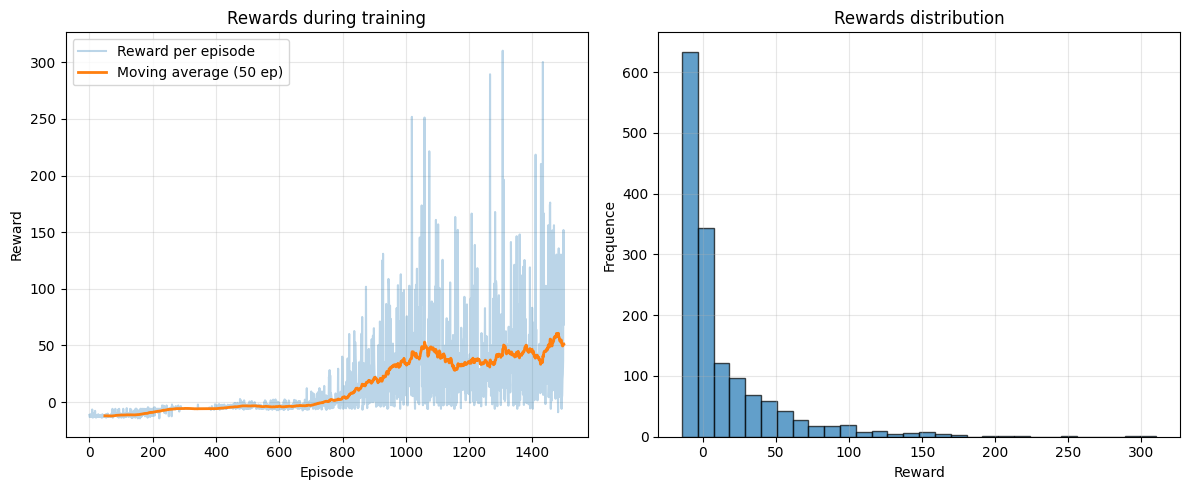

Plot saved as 'training_results.png'


In [29]:
print("Starting training...\n")

# train the agent
training_rewards = train_dqn(
    agent=agent,
    env=env,
    n_episodes=HYPERPARAMETERS['n_episodes'],
    max_steps=HYPERPARAMETERS['max_steps'],
    save_freq=HYPERPARAMETERS['save_freq'],
    print_freq=HYPERPARAMETERS['print_freq']
)

print("\nTraining completed")

# visualize results
plot_training_results(training_rewards)

Evaluating the trained agent...

Model loaded from best_flappy_model.pth
Episode 1/20 | Reward: 0.20 | Score: 0
Episode 1/20 | Reward: 0.40 | Score: 0
Episode 1/20 | Reward: 0.60 | Score: 0
Episode 1/20 | Reward: 0.80 | Score: 0
Episode 1/20 | Reward: 1.00 | Score: 0
Episode 1/20 | Reward: 1.20 | Score: 0
Episode 1/20 | Reward: 1.40 | Score: 0
Episode 1/20 | Reward: 1.60 | Score: 0
Episode 1/20 | Reward: 1.80 | Score: 0
Episode 1/20 | Reward: 2.00 | Score: 0
Episode 1/20 | Reward: 2.20 | Score: 0
Episode 1/20 | Reward: 2.40 | Score: 0
Episode 1/20 | Reward: 2.60 | Score: 0
Episode 1/20 | Reward: 2.80 | Score: 0
Episode 1/20 | Reward: 3.00 | Score: 0
Episode 1/20 | Reward: 3.20 | Score: 0
Episode 1/20 | Reward: 3.40 | Score: 0
Episode 1/20 | Reward: 3.60 | Score: 0
Episode 1/20 | Reward: 3.80 | Score: 0
Episode 1/20 | Reward: 4.00 | Score: 0
Episode 1/20 | Reward: 4.20 | Score: 0
Episode 1/20 | Reward: 4.40 | Score: 0
Episode 1/20 | Reward: 4.60 | Score: 0
Episode 1/20 | Reward: 4.80 | 

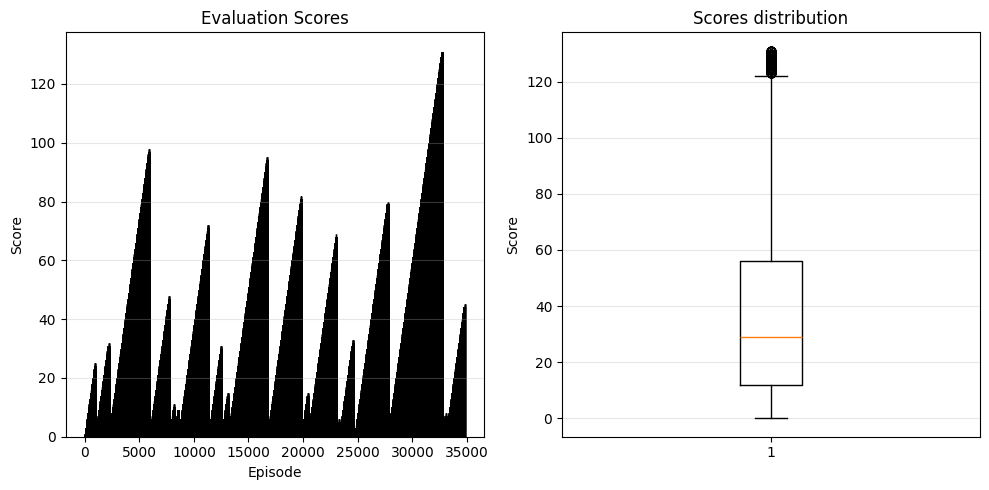

Plot saved as 'evaluation_results.png'


In [30]:
# evaluate the agent
print("Evaluating the trained agent...\n")

# load the best model
agent.load('best_flappy_model.pth')

# evalueate
eval_rewards, eval_scores = evaluate_agent(agent=agent, env=env, n_episodes=20,render=False)

# graph the results
plot_evaluation_results(eval_scores)